# Olympics Data (1896-2016) Exploration
## By Shuaib Ahmed

## Investigation Overview

In this investigation, I sought to examine how the Olympics has evolved, including participation (counts), personal attributes of athletes (Age, Height and Weight) and performance (medals attained) of athletes, medalists, nations and different events related to the corresponding Summer and Winter seasons.

## Dataset Overview

This is a Historical dataset on the modern Olympic Games, including all the Games from Athens 1896 to Rio 2016. These include basic biographical data on athletes (Age, Height, Sex and Weight) and medal results. Both Seasons, Summer and Winter, are included.
<br>
There were 271,116 observations about athletes surrounding the biographical data. Personal attributes that were numeric were missing due to the technological constraints regarding earlier versions of the Olympics to record Age, Height and Weight. Hence, I would separate a copy for analysis that would involve these variables which I would filter out the null values eventually while utilising the other variables as usual for analysis.
<br> 
The only meaningful transformation I performed was on the Weight variable, which exhibited a log-normal distribution as values ranged from 25-214kg - so a log-transformation would alleviate this problem of interpretation and would help discern visualisations involving Weight once this was performed.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# Use os and glob to locate files
import os 
import glob 

try:
    path= 'Olympics-dataset/'
    os.chdir(path)
except FileNotFoundError:
    print('file found already, check current directory')
    pass

In [4]:
# Check 
os.getcwd()

'/Users/ShuaibAhmed/Desktop/DAND-projects /Data-viz-olympics-project/Olympics-dataset'

In [5]:
# Load in the dataset into a pandas dataframe

olympics = pd.read_csv('olympics-master.csv')

# Correct data types

olympics['ID'] = olympics.ID.astype('object')
olympics['Sex'] = olympics.Sex.astype('category')
olympics['Season'] = olympics.Season.astype('category')

order = ['None', 'Bronze', 'Silver', 'Gold'] # From lowest-highest
ordered_cat = pd.api.types.CategoricalDtype(ordered= True, categories = order)
olympics['Medal'] = olympics.Medal.astype(ordered_cat)

In [6]:
assert olympics['ID'].dtypes == 'object'
assert olympics['Sex'].dtypes == 'category'
assert olympics['Season'].dtypes == 'category'
assert olympics['Medal'].dtypes == 'category'

In [7]:
# Numerical variables of immediate interest
numeric_vars = ['Age', 'Height', 'Weight']

# Categorical variables of interest (all)
category_vars = ['Sex', 'Season', 'Medal']

In [8]:
olympics_numerical = olympics.query("(Age > 0.0) & (Height > 0.0) & (Weight > 0.0)").copy()

def log_trans(y, inverse = False):
    """ A function to transform the specified y variable to a log,
    while preserving its original value by taking the inverse
    simultaneously """
    if not inverse:
        return np.log10(y) # we want to transform
    else:
        return np.power(10, y) # we want to preserve (orig values)
    
# Feature engineering to transform weight variable to log 
olympics_numerical['log_weight'] = olympics_numerical['Weight'].apply(log_trans)

In [9]:
# Winter hosts 
filter_winter = olympics['Season'].isin(['Winter'])
olympics_winter_hosts = olympics.loc[filter_winter].copy()
olympics_winter_hosts[['Year', 'City']].drop_duplicates().sort_values('Year')

# Summer hosts 
filter_summer = olympics['Season'].isin(['Summer'])
olympics_summer_hosts = olympics.loc[filter_summer].copy()
olympics_summer_host = olympics_summer_hosts[['Year', 'City']].drop_duplicates().sort_values('Year')

In [10]:
# Constructing pivot tables for winter and summer editions
# Use NOC as the key to join different tables 
medal_counts_winter = olympics_winter_hosts.pivot_table(columns= 'NOC', values= 'Name'\
                                                       , aggfunc= 'count', index= 'Year')
medal_counts_summer = olympics_summer_hosts.pivot_table(columns= 'NOC', values= 'Name'\
                                                       , aggfunc= 'count', index= 'Year')

# Calculating fractions of total medals won by country per year
fractions_winter = medal_counts_winter.divide(olympics_winter_hosts.shape[0], axis='rows')
fractions_summer = medal_counts_summer.divide(olympics_summer_hosts.shape[0], axis='rows')

In [11]:
# Use the expanding mean - mean considering all the data available up to that point in time
mean_winter_fractions = fractions_winter.expanding().mean()
mean_summer_fractions = fractions_summer.expanding().mean()

# Computing the percentage change
fractions_winter_change = mean_winter_fractions.pct_change() * 100
fractions_summer_change = mean_summer_fractions.pct_change() * 100

# Reset the index 
fractions_winter_change = fractions_winter_change.reset_index()
fractions_summer_change = fractions_summer_change.reset_index()

In [12]:
# We need it in tidy form for eventual analysis
panel_winter = pd.melt(fractions_winter_change, id_vars= 'Year', value_name= 'Pct_change', var_name= 'NOC')
panel_summer = pd.melt(fractions_summer_change, id_vars= 'Year', value_name= 'Pct_change', var_name= 'NOC')

In [13]:
# Building summer hosts 
olympic_summer_hosts = olympics_summer_hosts[['Year', 'City']].drop_duplicates().sort_values('Year')
summer_hosts = olympic_summer_hosts.reset_index(drop=True)

# Change cities: Antwerp for Athens and vice-versa
summer_hosts = summer_hosts.replace({'Antwerp':'Athens'})
summer_hosts.at[6,'City'] = 'Antwerp'

# Correct Roma to Rome
summer_hosts = summer_hosts.replace({'Roma':'Rome'})

# Drop Athens 1906 as it was a subset and not counted by the IOC
# Drop Stockholm 1956 as it was subset as well
summer_hosts = summer_hosts.drop(summer_hosts.index[[3,13]])

# Map the NOCs
mapping = {'Athens': 'GRE', 'Paris': 'FRA', 'St. Louis': 'USA', 'London':'GBR', 'Stockholm':'SWE'\
          , 'Antwerp':'BEL', 'Amsterdam':'NED', 'Los Angeles':'USA', 'Berlin':'GER', 'Helsinki':'FIN'\
          , 'Melbourne':'AUS', 'Rome':'ITA', 'Tokyo':'JPN', 'Mexico City':'MEX', 'Munich':'FRG'\
          , 'Montreal':'CAN', 'Moscow':'URS', 'Seoul':'KOR', 'Barcelona':'ESP', 'Atlanta':'USA'\
          , 'Sydney':'AUS', 'Beijing':'CHN', 'Rio de Janeiro':'BRA'}

summer_hosts['NOC'] = summer_hosts['City'].map(mapping)

In [14]:
olympic_winter_hosts = olympics_winter_hosts[['Year', 'City']].drop_duplicates().sort_values('Year')
winter_hosts = olympic_winter_hosts.reset_index(drop=True)
winter_hosts

# Map the NOCs
mapping = {'Chamonix':'FRA', 'St. Moritz':'SUI', 'Lake Placid':'USA', 'Garmisch-Partenkirchen':'GER'\
          , 'Oslo':'NOR', 'Cortina':'ITA', 'Squaw Valley':'USA', 'Innsbruck':'AUT','Grenoble':'FRA'\
          , 'Sapporo':'JPN', 'Sarajevo':'YUG', 'Calgary':'CAN', 'Albertville':'FRA', 'Lillehammer':'NOR'\
          , 'Nagano':'JPN', 'Salt Lake City':'USA', 'Torino':'ITA', 'Vancouver':'CAN', 'Sochi':'RUS'}

winter_hosts['NOC'] = winter_hosts['City'].map(mapping)

In [15]:
# Final stage: merge dataframes for winter 
merged_winter = pd.merge(panel_winter, winter_hosts, how='inner')
winter_effect = merged_winter.set_index('Year').sort_index()

In [16]:
# Merge for summer 
merged_summer = pd.merge(panel_summer, summer_hosts, how='inner')
summer_effect = merged_summer.set_index('Year').sort_index()

## Proportion Statistics 1 - Sex and Season categories at the Olympics

The first bar chart shows that a large number of males (72.5%) relative to females (27.5%) participated at the Olympics (1896-2016). I found *after* the exploration that women's participation at the Olympics first came in 1900, which was minuscule at 2.7% out of a total of 997 athletes, with access to more popular events like athletics and gymnastics only coming in 1928 - which saw an increase in the participation rate by nearly 10% at the Olympic Games. This may be able to explain such a disparity - [see here](https://www.olympic.org/women-in-sport/background/key-dates).

The second bar chart also shows a large disparity, this time between the number of athletes competing at the Summer Olympics (82.1%) relative to the Winter Olympics (17.9%). One case I found eventually in the exploration revolved around the introduction of the Winter Olympics, which came into inauguration  in 1924. This can somewhat explain such a disparity.

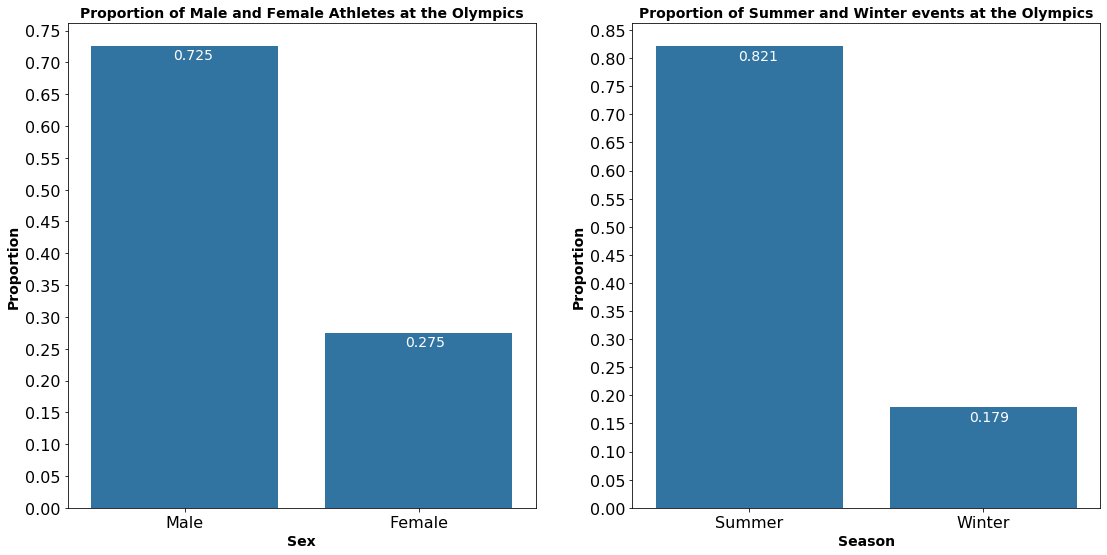

In [32]:
base_color = sns.color_palette()[0] # All bars are blue
font = {'size': 14,'weight': 'heavy'}

fig, ax = plt.subplots(ncols=2, figsize=[16,8])
# get proportion taken by most common group for derivation
# of tick marks
n_points = olympics.shape[0]
max_count = olympics['Sex'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop + 0.05, 0.05)
tick_names = [f'{v:0.2f}' for v in tick_props]

# generate plot 
sns.countplot(data= olympics, x='Sex', color= base_color, order = olympics['Sex'].value_counts().index, ax= ax[0])
ax[0].set_yticks(tick_props * n_points)
ax[0].set_yticklabels(tick_names)
ax[0].set_ylabel('Proportion', fontdict=font)
ax[0].set_xlabel('Sex', fontdict=font)
ax[0].set_title('Proportion of Male and Female Athletes at the Olympics', fontdict= font)
ax[0].text(-0.05, 191000, '0.725', color='w', size=14)
ax[0].text(0.94, 69000, '0.275', color='w', size=14)

n_points = olympics.shape[0]
max_count = olympics['Season'].value_counts().max()
max_prop = max_count / n_points

# tick marks and names
tick_props = np.arange(0, max_prop + 0.05, 0.05)
tick_names = [f'{v:0.2f}' for v in tick_props]

# generate plot 2
sns.countplot(data= olympics, x='Season', color= base_color, ax=ax[1])
ax[1].set_yticks(tick_props * n_points)
ax[1].set_yticklabels(tick_names)
ax[1].set_ylabel('Proportion', fontdict=font)
ax[1].set_xlabel('Season', fontdict=font)
ax[1].set_title('Proportion of Summer and Winter events at the Olympics', fontdict= font);
ax[1].text(-0.05, 216000, '0.821', color='w', size= 14)
ax[1].text(0.94, 42000, '0.179', color='w', size= 14)

plt.tight_layout();

## Proportion Statistics 2 - Standard Competitors and Medalists

From the first pie chart depicting the proportion of medalists and standard competitors (none), standard competitors at 85.3% stood out as the most represented, while around 14.6-14.7% out of all the competitors from 1896-2016 were medalists. Hence, this is an esteemed Accolade for Olympic athletes to earn.

The second pie chart concentrates on the medalists Olympians earned. There are some slight deviations considering there are supposedly an equal amount of medals to be earned. Gold medals were awarded the most at 33.6%, while bronze is next highest being marginally lower at 33.4%, while silver medals were awarded the least out of these, slightly lower at 33%. This [wiki](https://en.wikipedia.org/wiki/All-time_Olympic_Games_medal_table) clarifies why the total (proportion) of gold, silver and bronze medals are not equal.

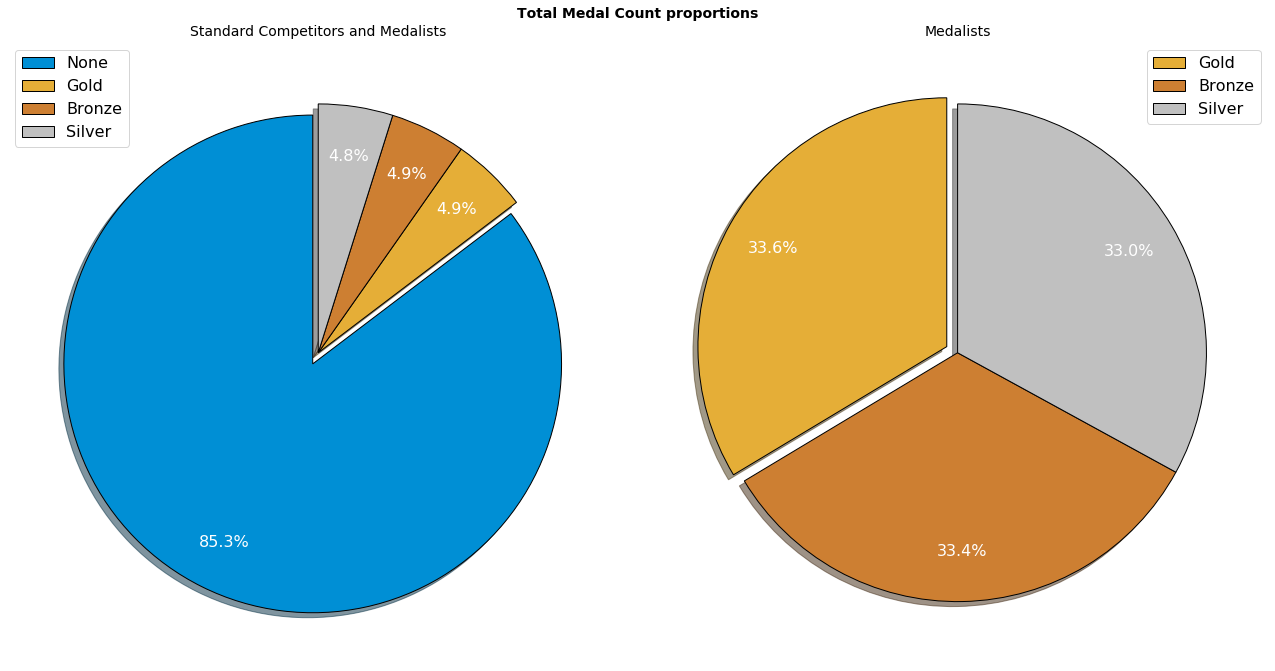

In [20]:
font = {'size': 14,'weight': 'medium'}

# Pie chart, where the slices will be ordered and plotted counter-clockwise
plt.figure(figsize = [18,10])
plt.subplot(1,2,1)
labels = ('None', 'Gold', 'Bronze', 'Silver') # Descending order
sizes = [231333, 13372, 13295, 13116]
explode = (0.05, 0, 0, 0) # Promote the largest portion
colors = ['#008fd5', '#e5ae37', '#CD7F32', '#C0C0C0'] # Color codes

plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%'
        , shadow=True, startangle=90, pctdistance=0.8,
        textprops=dict(color="w")
        , colors=colors, wedgeprops={'edgecolor': 'black'});

plt.legend(fontsize='medium', loc='upper left')
plt.title('Standard Competitors and Medalists', fontdict= font)
plt.suptitle('Total Medal Count proportions', size= 14, weight= 'heavy' ) # Main title

plt.subplot(1,2,2)
labels = ('Gold', 'Bronze', 'Silver') # Descending order
sizes = [13372, 13295, 13116]
explode = (0.05, 0, 0) # Promote the largest portion
colors = ['#e5ae37', '#CD7F32', '#C0C0C0'] # Color codes

plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%'
        , shadow=True, startangle=90, pctdistance=0.8,
        textprops=dict(color="w")
        , colors=colors, wedgeprops={'edgecolor': 'black'});

plt.tight_layout() # Maintains the spacing
plt.rcParams.update({'font.size': 16}) # size of proportion labels
plt.legend(fontsize='medium', loc= 'upper right')
plt.title('Medalists', fontdict= font)
plt.show();

## Fitted regression - Weight (kg) on Height (cm)

The weight data points for Olympic athletes in this dataset take a large range of values from 25kg at the lowest to 214kg at the highest
Using the log scale for weight alleviates this phenomenon, given the weight distribution among athletes appeared log-normal in my exploration earlier.  
When this transformation is performed, we see a predictable linear relationship between Weight and Height. The correlation coefficient (𝝆) is 0.8, illustrating a strong positive correlation. As height (cm) of Athletes increases, weight (kg) also increases.

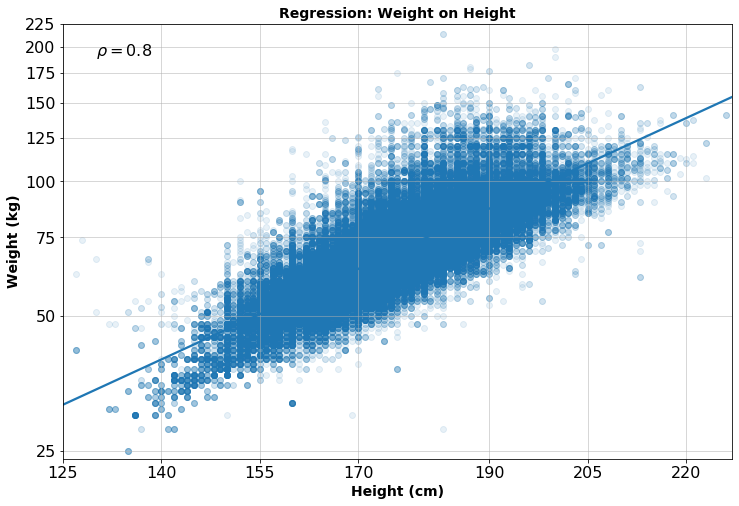

In [21]:
font = {'size': 14,'weight': 'heavy'}
font2 = {'size': 16,'weight': 'heavy'}
plt.figure(figsize = [12, 8])

# Regplot to illustrate this relationship fit closer 
g = sns.regplot(data = olympics_numerical, 
            x= olympics_numerical['Height'], 
            y= olympics_numerical['log_weight'], 
            scatter_kws = {'alpha' : 1/10})

# No need to set y scale - plt.yscale('log') - for log as its already transformed

tick_locs = np.arange(25, 214+25, 25)
plt.xlim(126,227)
plt.ylim(1.38, 2.34)
plt.yticks(log_trans(tick_locs), tick_locs)
plt.xticks([125, 140, 155, 170, 190, 205, 220], [125, 140, 155, 170, 190, 205, 220])
plt.ylabel('Weight (kg)', fontdict= font)
plt.xlabel('Height (cm)', fontdict= font)
plt.text(130, 2.28, r'$\rho=0.8$', fontdict = font2) # setting up annotation for corr coefficient
plt.grid(True, linestyle='-', linewidth=0.5)
plt.title('Regression: Weight on Height', fontdict= font)
plt.show();

## Histogram (2d) Heatmap - Weight (kg) on Height (cm)

Elaborating on the relationship between weight and height, the heatmap can roughly tell us where most athletes are grouped in terms of these personal attributes.
The 'hotspots' of shading also confirm that most (on average) athletes tend to be in the 160-180 cm height range as illustrated in the height distributions. Weight - as previously log-transformed - regarding athletes are mostly grouped in the 60-80 kg range.

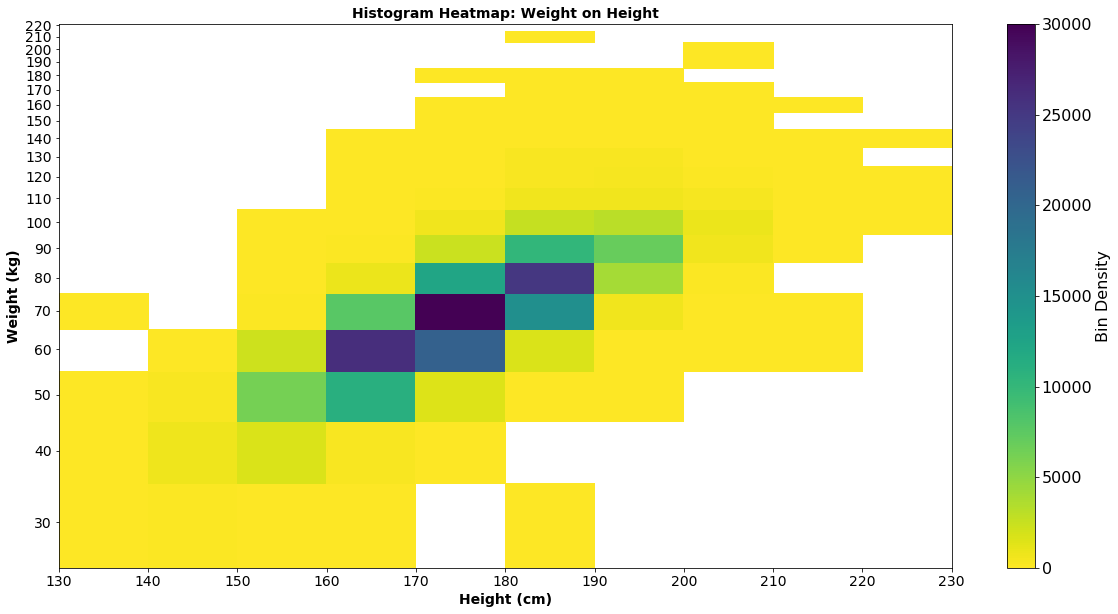

In [23]:
font = {'size': 14,'weight': 'heavy'}
plt.figure(figsize = [20, 10])
bins_x = np.arange(130, 226+10, 10)
bins_y = np.arange(25, 214+10, 10)

g = plt.hist2d(data= olympics_numerical, x= 'Height', y='Weight', 
          range= ((127,226),(25,214)), cmap='viridis_r',
          bins= [bins_x, bins_y], cmin=0.5)

plt.colorbar(label='Bin Density')
plt.clim((0,30000))
plt.ylim((25,221))
tick_locs = np.arange(30, 214+10, 10)
plt.yscale('log') # Log scale transformation centres where the frequent densities are
plt.yticks(tick_locs, tick_locs, fontsize=14)
plt.xticks(bins_x, bins_x, fontsize=14)
plt.ylabel('Weight (kg)', fontdict= font)
plt.xlabel('Height (cm)', fontdict= font)
plt.title('Histogram Heatmap: Weight on Height', fontdict= font);

## Descriptive statistics and distribution - Personal Attributes of Athletes categorised by Non-medalists and Medalists

The `violinplot` allows us to interpret the distribution and quartiles of each of the athletes' attributes - between standard competitors and medalists.
<br>
**Height** - The distribution for height among standard competitors (none) appears to be trimodal, where peaks exist between the 165-180 cm range. For each of the medal winners, height appears to be slightly negative (left) skewed centred between 175-180 cm, given that medal winners tend to be slightly taller than standard competitors.
<br>
**Age** - The age distribution looks positive (right) skewed centred at the middle of 20-25 years for all athletes (standard competitors and medalists). Only the median age for medalists in each medal class is slightly higher than for standard competitors.
<br>
**Weight** - Weight for standard competitors, appears to be *slightly* trimodal, given peaks between 60-80 kg. The weight distributions for each medalist class look evenly distributed after the log transformation, mainly centred around 70-75 kg. Median weight for medalists in each medal class is higher than for standard competitors, though silver and gold medalists weighed slightly more than bronze medalists.

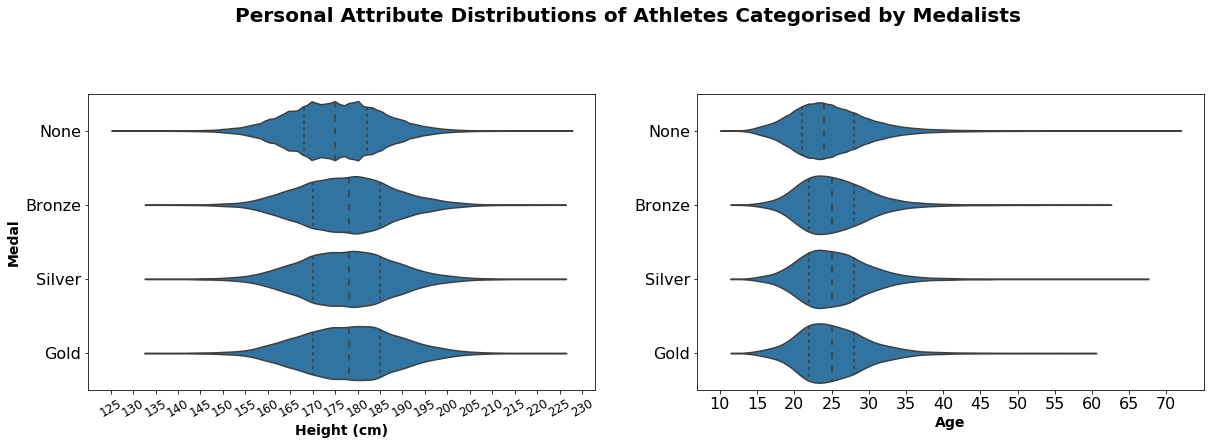

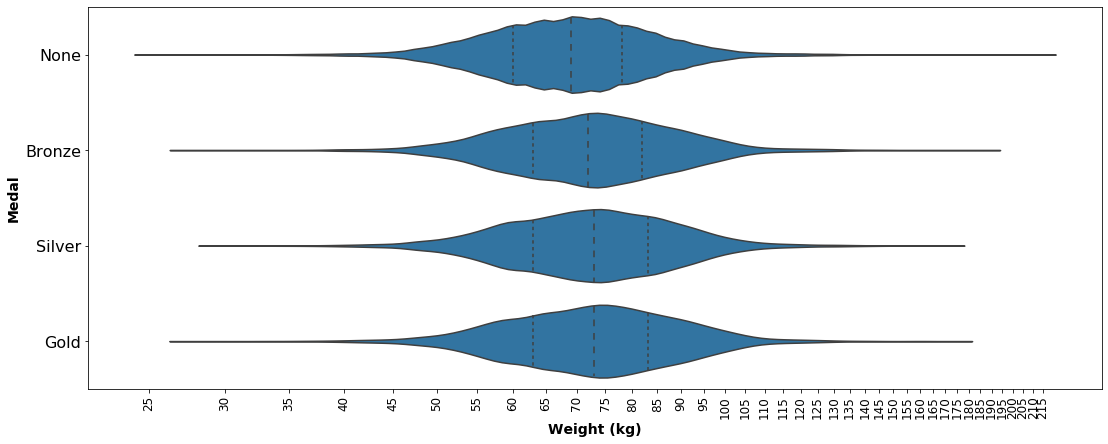

In [24]:
font = {'size': 14,'weight': 'heavy'}
base_color = base_color

plt.figure(figsize = [20, 12])

plt.subplot(2,2,1)
sns.violinplot(data = olympics_numerical, y='Medal', x='Height', color= base_color, inner='quartile')
plt.xticks(np.arange(125, 226+5, 5), rotation= 30, size=12)
plt.xlabel('Height (cm)', fontdict= font)
plt.ylabel('Medal', fontdict= font)
plt.suptitle('Personal Attribute Distributions of Athletes Categorised by Medalists', size= 20, weight= 'heavy')

plt.subplot(2,2,2)
sns.violinplot(data= olympics_numerical, y='Medal', x='Age', color = base_color, inner='quartile')
plt.xticks(np.arange(10, 70+5, 5))
plt.xlabel('Age', fontdict= font)
plt.ylabel(None);

plt.figure(figsize = [30, 12])
plt.subplot(2,2,3)
sns.violinplot(data= olympics_numerical, y='Medal', x='log_weight', color = base_color, inner='quartile')
tick_locs = np.arange(25, 214+5, 5)
plt.xticks(log_trans(tick_locs), tick_locs, rotation= 90, size=12)
plt.xlabel('Weight (kg)', fontdict= font)
plt.ylabel('Medal', fontdict=font);

plt.tight_layout();

## Summer Olympics - is there a Host advantage?

In terms of the Summer Olympics, the early years since its inauguration (Athens 1896) have a significant effect on medals earned. Since data for comparisons was able to be collected from 1900 (Paris 1900) for these expanding statistics (mean considering all the data available up to that point in time for those countries/NOCs), Paris (France) seems to be a massive outlier with around a 2000% increase from the prior edition, which drastically declines but remains high for the next four host cities/countries, gradually declining between 450-100% - USA, Britain, Sweden and Belgium respectively.

However, between 1920 Antwerp (Belgium) and 2016 Rio de Janeiro (Brazil), there were not many cities/countries that had a significant enough effect of winning medals (≈50-100%) when they were hosts other than 1956 Melbourne (Australia), 1968 Mexico City (Mexico) and 1988 Seoul (South Korea). 

Therefore, the host advantage with regards to the Summer Olympics has diminished **overall** and cannot fully explain how a host is meant to perform/excel typically but can be insightful to suggest that being a host city can somewhat contribute to a country's success as is empirically shown for some past countries/cities.

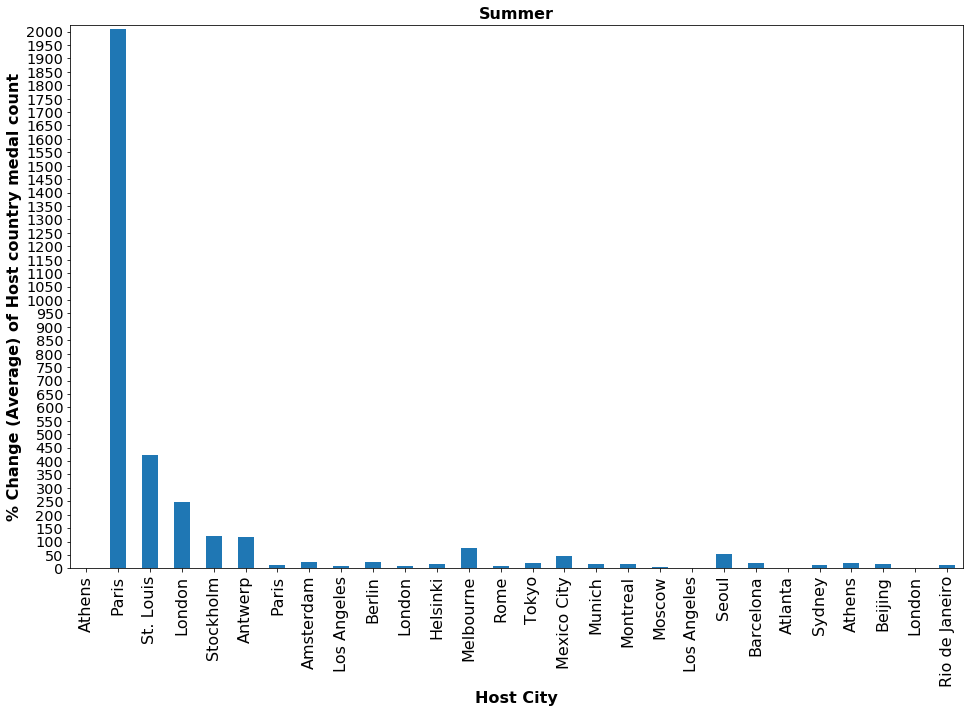

In [31]:
font = {'size': 16,'weight': 'heavy'}

summer_effect.plot(kind= 'bar', x='City', y='Pct_change', legend=False, title='Summer', figsize=[16,10])
tick_locs = np.arange(0, 2000+50, 50)
plt.title('Summer', fontdict=font)
plt.ylim((0,2025))
plt.yticks(tick_locs, tick_locs, size=14.5)
plt.ylabel('% Change (Average) of Host country medal count', fontdict= font)
plt.xlabel('Host City', fontdict=font);

## Winter Olympics - is there a Host advantage?

For hosts countries/cities at the Winter Olympics, the highest effect for medals earned by a city since the Winter Olympics inauguration in 1924 (Chamonix - France) also came early on via the fourth edition, 1948 St. Moritz (Switzerland) at around 40%, but compared to Summer Olympic editions, this is marginal compared to other summer host successes.

Between 1948 St. Moritz and 2014 Sochi (Russia), only Sarajevo (then known as Yugoslavia) in 1984 managed to get anywhere close to this with total medals earned at 25% compared to previous years of participation.

Like above with summer hosts, the host advantage with regards to the Winter Olympics has diminished **overall** but was never that significant to begin with relative to Summer Olympics editions. Hence, this is not promising enough to suggest an overall performance boost from being a winter host, but as somewhat shown empirically, it can marginally contribute to a country's success at the Winter Olympics.

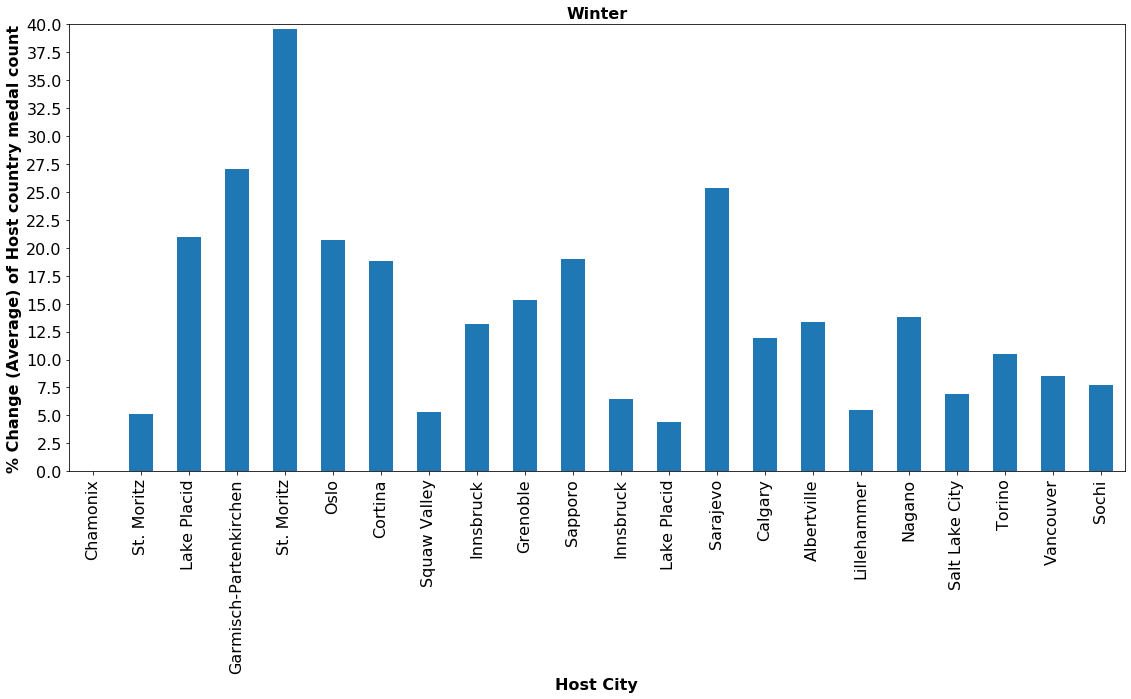

In [27]:
font = {'size': 16,'weight': 'heavy'}
winter_effect.plot(kind='bar', x='City', y='Pct_change', legend=False, title='Winter', figsize=[16,10])
plt.title('Winter', fontdict= font)
plt.ylabel('% Change (Average) of Host country medal count', fontdict= font)
plt.ylim((0,40))
plt.xlabel('Host City', fontdict= font)
tick_loc2 = np.arange(0,40+2.5, 2.5)
plt.yticks(tick_loc2, tick_loc2)
plt.tight_layout();

## Age - categorised by Medalists (Non-medalists) and Sex

**Age** - On average, male athletes (except for Bronze medalists) tend to be *slightly* older than their female counterparts.

For male athletes, be it standard competitors or medalists, on average, the median age is the same at 25 years, with little sign of uncertainty (variance) about the data points in this region.

However, there are differences between the age of female standard competitors and medalists. Standard female competitors tended to be the youngest group with a median of 23 years, while female bronze medalists tend to be the oldest group with a median of 25 years - albeit with wide lower uncertainty of data points between 24-25 years. Silver and gold Female medalists tend to be grouped under 24 years, given the median in this regard.

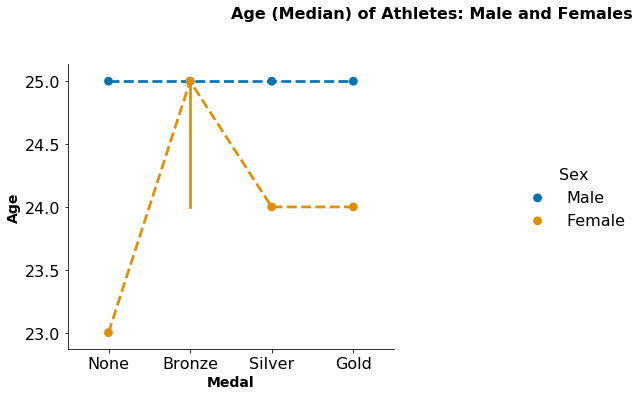

In [28]:
# Take the median as an estimator - data for personal features have slightly skewed distributions in few cases
from numpy import median

font = {'size': 14,'weight': 'heavy'} # Font title size

sns.catplot(data= olympics_numerical, x='Medal', y='Age', kind='point', aspect=1.2, height=5
           , palette= sns.color_palette('colorblind')[:2], hue='Sex', hue_order=['Male','Female'], linestyles='--'
           , estimator= np.median)

# Use text to customise title location for better viewing
plt.text(1.5, 25.5, 'Age (Median) of Athletes: Male and Females', size= 16, weight= 'heavy') 
plt.xlabel('Medal', fontdict=font)
plt.ylabel('Age', fontdict=font)
plt.show();

## Height (cm) - categorised by Medalists (Non-medalists) and Sex

**Height** - On average, male athletes tend to taller than their female counterparts.

For both male and female athletes, standard competitors are shorter than medalists at around 179 cm (male) and 168 cm (female); compared with bronze and Silver medalists, athletes possess a height of around 181 cm, while Gold medalists tend to be at the height of around 182 cm (male), whereas female athletes tend to have possessed a height of 170 cm in each medal category on average.

In terms of uncertainty (variance) about the height medians, it tended to be slightly upper/lower for both sexes. 
<br>
Male standard competitors and bronze medalists illustrate lower-bound variance about their respective height medians, while male silver medalists illustrate upper-bound variance about the median. There was little/no variance about the height median for gold male medalists.

Female standard competitors similarly illustrate lower-bound variance about their respective medians, whereas there is little/no variance about the median of bronze female medalists. Female silver and gold medalists illustrate upper-bound variance about their respective medians.

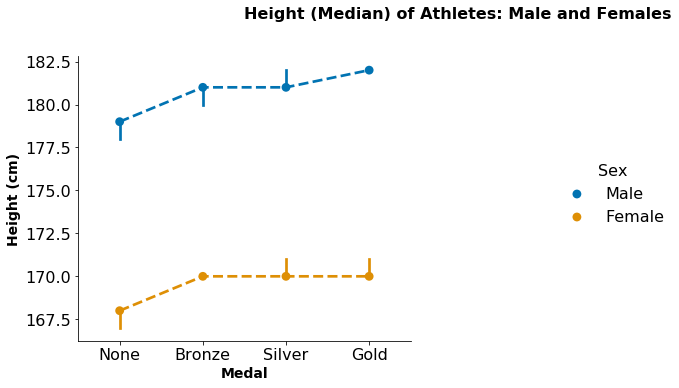

In [29]:
font = {'size': 14,'weight': 'heavy'}

sns.catplot(data= olympics_numerical, x='Medal', y='Height', kind='point', aspect=1.2, height=5
           , palette= sns.color_palette('colorblind')[:2], hue='Sex', hue_order=['Male','Female'], linestyles='--'
           , estimator= np.median)
plt.ylabel('Height (cm)')
plt.text(1.5, 185, 'Height (Median) of Athletes: Male and Females', size= 16, weight='heavy')
plt.xlabel('Medal', fontdict=font)
plt.ylabel('Height (cm)', fontdict=font)
plt.show();

## Weight (kg) - categorised by Medalists (Non-medalists) and Sex

**Weight** - On average, male athletes tend to be heavier than their Female counterparts. This variable was also log-transformed as above.

For both male and female athletes, standard competitors (none) are lighter than medalists at around 75 kg (male) and 59 kg (female); compared with bronze and silver medalists, athletes weigh around 78 kg, while gold medalists tend to weigh around 80 kg (male), whereas female athletes weigh around 63-64 kg in each medal category on average.

In terms of uncertainty (variance) about the weight medians, it tended to be *very* slightly upper/lower for males, while there was only lower uncertainty for females. 
<br>
Male standard competitors present little/no variance about their weight medians. Bronze male medalists illustrate *slight* lower-bound variance, while male silver medalists illustrate *slight* upper-bound variance about their respective median. There was *slight* lower-bound variance about the median weight for gold male medalists.

Female standard competitors similarly present little/no variance about their median weight, whereas there is slight lower-bound variance about the median of bronze and silver female medalists. There was little/no variance upper-bound about the median weight for gold female medalists.

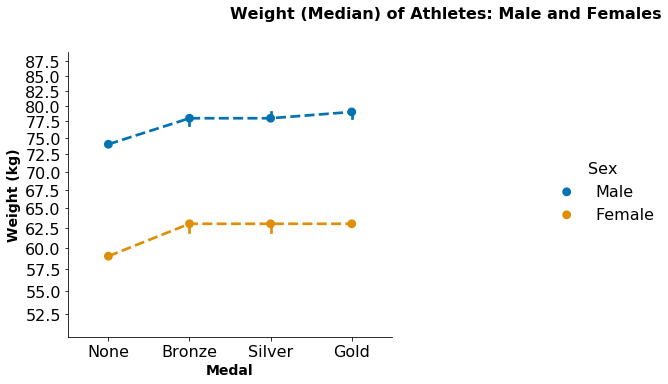

In [30]:
font = {'size': 14,'weight': 'heavy'}

sns.catplot(data= olympics_numerical, x='Medal', y='log_weight', kind='point', aspect=1.2, height=5
           , palette= sns.color_palette('colorblind')[:2], hue='Sex', hue_order=['Male','Female'], linestyles='--' 
           , estimator= np.median)
tick_locs = np.arange(25, 214+2.5, 2.5)
plt.yticks(log_trans(tick_locs), tick_locs)
plt.ylim((1.7,1.95))
plt.ylabel('Weight (kg)')
plt.text(1.5, 1.98, 'Weight (Median) of Athletes: Male and Females', size= 16, weight='heavy')
plt.xlabel('Medal', fontdict=font)
plt.ylabel('Weight (kg)', fontdict=font)
plt.show();